# CellMap Tutorial

This [notebook](cell_map_tutorial.ipynb) is a tutorial to run the main processing script that quantifies immediate early gene expression from lightsheet data of iDISCO+ cleared brains.

In [ ]:
__author__    = 'Christoph Kirst <christoph.kirst.ck@gmail.com>'
__license__   = 'GPLv3 - GNU General Public License v3 (see LICENSE)'
__copyright__ = 'Copyright © 2020 by Christoph Kirst'
__webpage__   = 'https://idisco.info'
__download__  = 'https://www.github.com/ChristophKirst/ClearMap2'

### Initialize workspace

The following sets up the directories and filenames for a CellMap project. 

The raw files and files generated during the analysis of a data set are managed via the [workspace](/api/ClearMap.IO.Workspace.html).

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from ClearMap.IO import IO as clearmap_io
from ClearMap.IO import Workspace as wsp
from ClearMap import Settings as settings
from ClearMap.Alignment import Annotation as ano
from ClearMap.Alignment import Resampling as res
from ClearMap.Alignment import Elastix as elx
from ClearMap.Analysis.Measurements import Voxelization as vox

from ClearMap.Visualization.Qt import Plot3d as p3d
from ClearMap.Visualization.Vispy import Plot3d as vispy_p3d
from ClearMap.Visualization.Matplotlib import PlotUtils as plot_utils

from ClearMap.ImageProcessing.Experts import Cells as cells

In [ ]:
# directories and files
directory = Path('~/Programs/ClearMap2/ClearMap/Tests/Data/CellMap_Example').expanduser()    

expression_raw      = 'Raw/Fos/Z<Z,4>.tif'           
expression_auto     = 'Autofluorescence/Auto/Z<Z,4>.tif'  

ws = wsp.Workspace('CellMap', directory=directory)
ws.update(raw=expression_raw, autofluorescence=expression_auto)
ws.debug = False

resources_directory = settings.resources_path

ws.info()

The output is a list of existing files in the project. As the project is new, only the raw data files and the autofluorescence images exist. 

* `directory` refers to the folder where the project data are located, and where all results will be written.


* `expression_raw` refers to the source files for the raw data. It can be just a singe file name if the data is stored in a single file. If the raw data comes as a list of files, this can be an [TagExpression](/api/ClearMap.Utils.TagExpression.html) of the file names.

  For example, if the files written by the microscope are `Z0001.tif`, `Z0002.tif`, etc..., where the number refers to the plane of the stack those files can be used together as aa common source using a tag expression `Z<Z,4>.tif`. 

  A tag is a placeholder for a number or a name and has the general form `<Name, Type, Width>` (see [TagExpression](/api/ClearMap.Utils.TagExpression.html)), and if `Type` is omitted the tag is assumed to be digits. `Name` is the name of the tag and `Width` the number of chars or digits.

  Here we use <Z,4> to denote that the images are numbered along the z-axis and that there are 4 digit with trailing zeros that number the images.

* `expression_auto` refers to the autofluorescence channel acquisition. It is handled the same way as `expression_raw`.
   
   <div class="alert alert-info">
   Tip
    
   You don’t have to type in the complete filenames yourself! In Linux Ubuntu, you can click on the file whose path you want to get in the file explorer and ‘copy’ (`ctrl + c`), and then go back on the script and ‘paste’ (`ctrl + v`), and the full path of the file will be put in.
   </div>
       

<div class="alert alert-info">  
Note
    
All file specifications are with respect to the working directory, which is automatically added to all paths.
</div>

### Initialize alignment 

First initialize the atlas reference files by roughly slicing them to the part of the brain under consideration. 
E.g. here our data set is half a brain, and we slice the corresponding hemisphere from the reference atlas.

<div class="alert alert-info">
Note

It is important that the alignment template and annotation file match the field of view of your acquisition. By default, they cover the whole brain, but if you acquired a smaller region of the brain (for instance only one hemisphere), you need to prepare new versions of these files to match the coverage of the brain from your acquisition. Also, the orientation in space of these images in these files needs to match the orientation of the brain during your acquisition. The original file themselves are located in the 'ClearMap/Resources/Atlas’ folder and cropped files will be stored there as well.
</div>

In [ ]:
# init atlas and reference files
annotation_file, reference_file, distance_file=ano.prepare_annotation_files(
    slicing=(slice(None),slice(None),slice(0,256)), orientation=(1,-2,3),
    overwrite=False, verbose=True);

Next we initialize the parameter files to be used for the alignment via elastix.
We provide a template files in ClearMap that typically don't need to be modified unless you 
experience problems with the alignment.

In [ ]:
# alignment parameter files    
align_channels_affine_file   = clearmap_io.join(resources_directory, 'Alignment/align_affine.txt')
align_reference_affine_file  = clearmap_io.join(resources_directory, 'Alignment/align_affine.txt')
align_reference_bspline_file = clearmap_io.join(resources_directory, 'Alignment/align_bspline.txt')

If you eed to stitch tiled data sets please refer to the [Stitching](tube_map_tutorial.ipynb#Stitching) section in the [TubeMap tutorial](tube_map_tutorial.ipynb)

## Visualization

*ClearMap* comes with a many tools to visualize the data ([Visualization](Api/ClearMap.Visualization.rst))

To visualize 3d image data ClearMap provides a data explorer:

In [ ]:
p3d.plot(ws.filename('raw'))

*ClearMap's* data viewer opens in a new window allowing you to inspect the data:

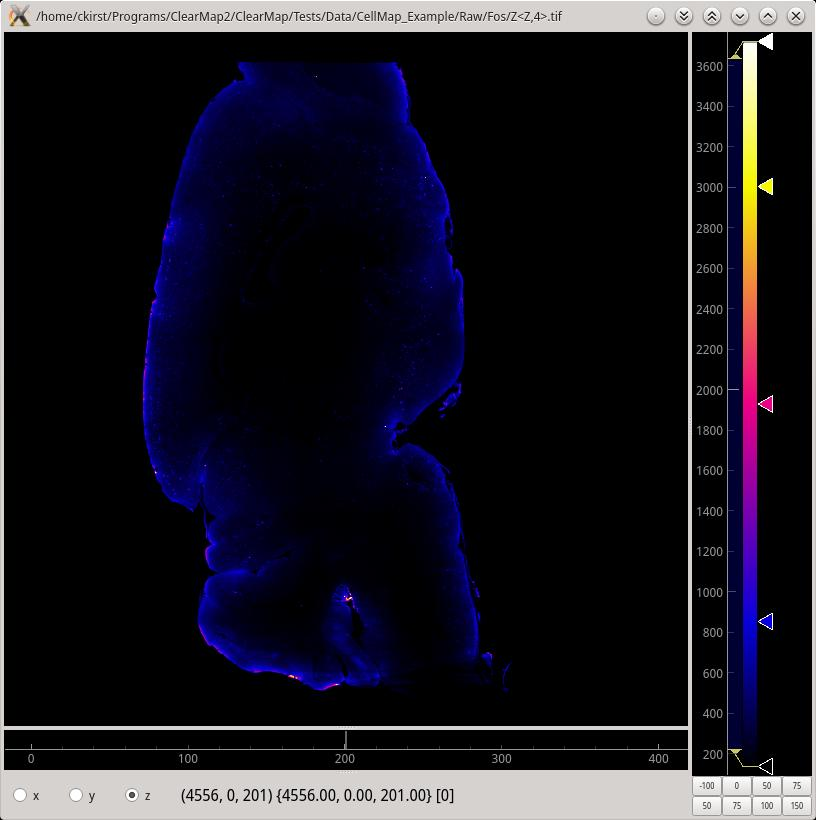

You can also open more files at the same time with synchronized windows to inspect them simultaneously. 
For this, pass a list of files to the plot command:

You can also overlay several files by specifying an inner list of files to overlay in a single window:

In [ ]:
p3d.plot(ws.file_list('raw')[0:2])

In [ ]:
p3d.plot([ws.file_list('raw')[0:2]])

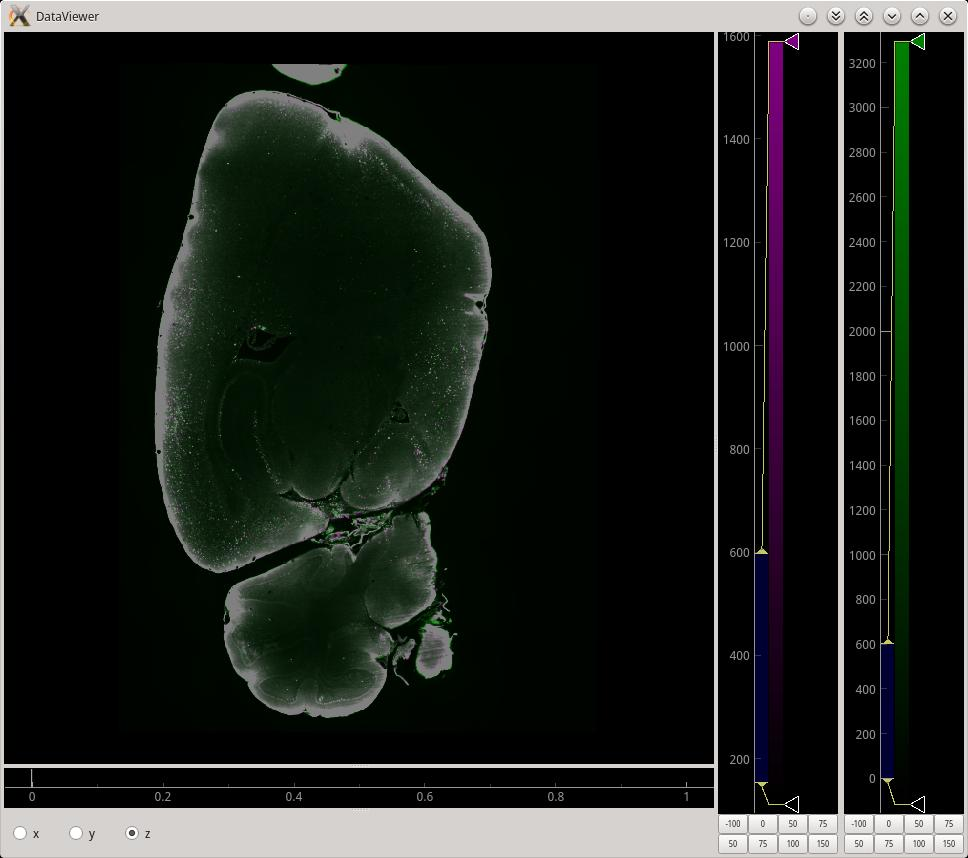

<div class="alert alert-info">
Note

In order to open nmpy binary files with [ImageJ](https://imagej.net/Fiji) you ClearMap can write a mhd header using the function `write_header_from_source` in the [MHD module](/api/ClearMap.IO.MHD.html) and opening this header file in [ImageJ](https://imagej.net/Fiji).
</div>

In [ ]:
clearmap_io.mhd.write_header_from_source(ws.filename('stitched'))

## Stitching

Stitching can be done using *ClearMap's* [WobblyStitcher](wobblystitcher.rst).

You can refer to the [Stitching section](tube_map_tutorial.ipynb#Stitching) in the [TubeMap tutorial](tube_map_tutorial.ipynb)

## Data conversion

To speed up processing it can be useful to first convert the microscope data to a numpy binary file.
This step is not necessary though.

In [ ]:
##%% Convert raw data to npy file     
             
source = ws.source('raw')
sink   = ws.filename('stitched')
clearmap_io.convert(source, sink, verbose=True)

We assume you either stitched the data or converted it and use the `ws.filename('stitched')` for the raw data in the following.

## Resampling and atlas alignment 

Here we will align the scan with the reference atlas. As mentioned before, make sure the template
and annotation files are in the same orientation as the brain scan, and that their field of view 
covers more or less the same regions.


### Resampling - raw data

In the resampling and alignment step, there are only a few parameters to check:

* `source_resolution` is the resolution of the data as `(x-resolution, y-resolution, z-resolution)`. 

   
* `sink-resolution` is the resolution of the Atlas. We use the 25µm version of the annotation.   

In [ ]:
resample_parameter = {
    "original_resolution" : (1.625, 1.625, 1.6),
    "resampled_resolution"   : (25, 25, 25),
    "processes" : None,
    "verbose" : True,
}

res.resample(original=ws.filename('stitched'), resampled=ws.filename('resampled'), **resample_parameter)

### Resampling - autofluorescence

* `source_resolution` refers to the autofluorescence scan. 


In [ ]:
resample_parameter_auto = {
    "original_resolution" : (5, 5, 6),
    "resampled_resolution"   : (25, 25, 25),
    "processes" : None,
    "verbose" : True,
}

res.resample(original=ws.filename('autofluorescence'), 
             resampled=ws.filename('resampled', postfix='autofluorescence'), 
             **resample_parameter_auto)

# p3d.plot([ws.filename('resampled'), ws.filename('resampled', postfix='autofluorescence')])

Note that the orientation of the sample has to be set to match the orientation of the Atlas reference files. It is not mandatory to acquire the sample in the same orientation as the atlas. For instance, you can acquire the left side of the brain, and map it onto the right side of the atlas by adding `"orientation":(1,2,3)`
to the `resample_parameter`. 

The numbers indicate the axes order starting from 1 to d and a negative axis number indicates reversal of that axis. E.g.:

| Orientation | Description                                              |
|:------------|:---------------------------------------------------------|
| (1, 2, 3)   | The scan has the same orientation as the atlas reference |
| (-1, 2, 3)  | The x axis is inverted compared to the atlas             |
| (1, -2, 3)  | The y axis is inverted compared to the atlas             |
| (2, 1, 3)   | Exchanges the x and y axis                               |
| (3, 2, -1)  | Exchanges the z and x axis and inverts the new z-axis.   |


For our samples, we use the following orientation to match our atlas files:

* The right side of the brain is facing the objective, lateral side up.

* The rostral side of the brain is up

* The dorsal side is facing left

* The ventral side is facing right

In this situation, if we want to image the right hemisphere, we use (1, 2, 3) and if we want to image the left hemisphere, we use (-1, 2, 3).


### Alignment  - resampled to autofluorescence

This step interfaces to [elastix](https://elastix.lumc.nl/) to align the resampled raw image to the resampled autofluorescence image.

As the autofluorescence image is often taken in a separate step with different microscope settings both images typically do not align. This steps corrects for this via an affine transformation.

In [ ]:
# align the two channels
align_channels_parameter = {            
    # moving and reference images
    "moving_image" : ws.filename('resampled', postfix='autofluorescence'),
    "fixed_image"  : ws.filename('resampled'),
    
    # elastix parameter files for alignment
    "affine_parameter_file"  : align_channels_affine_file,
    "bspline_parameter_file" : None,
    
    # directory of the alignment result '~/ClearMap_Resources/Par0000affine.txt',
    "result_directory" :  ws.filename('elastix_resampled_to_auto')
}

elx.align(**align_channels_parameter)

### Alignment - autofluorescence to reference

This step aligns the resampled autofluorescence image to the atlas reference via a non-linear transformation.

In [ ]:
# align autofluorescence to reference
align_reference_parameter = {            
    # moving and reference images
    "moving_image" : reference_file,
    "fixed_image"  : ws.filename('resampled', postfix='autofluorescence'),
    
    # elastix parameter files for alignment
    "affine_parameter_file"  :  align_reference_affine_file,
    "bspline_parameter_file" :  align_reference_bspline_file,
    # directory of the alignment result
    "result_directory" :  ws.filename('elastix_auto_to_reference')
    }

elx.align(**align_reference_parameter)

The alignment step should last for about 2 to 10 minutes and generate two files: 
`ws.filename('resampled')` and `ws.filename('resampled', postfix='autofluorescence'))`, as well as 2 folders: `elastix_resampled_to_auto` and `elastix_auto_to_reference`. 

You can check the quality of the alignment. The easiest is to use [Fiji (Image J)](https://imagej.net/Fiji). Open the following files: `ws.filename('resampled')` and `ws.filename('resampled', postfix='autofluorescence'))`. These are the original we need to align. 

Then go into the `elastix_resampled_to_auto` folder. This is the alignment of the resampled data to the resampled autofluorescence image. Open the `result.0.mhd` file. 

Then go to the folder `elastix_auto_to_reference`. This is the result of the alignment of the autofluorescence to the Atlas reference. Open the `result.1.mhd file`. 

Organize the files as follows: 

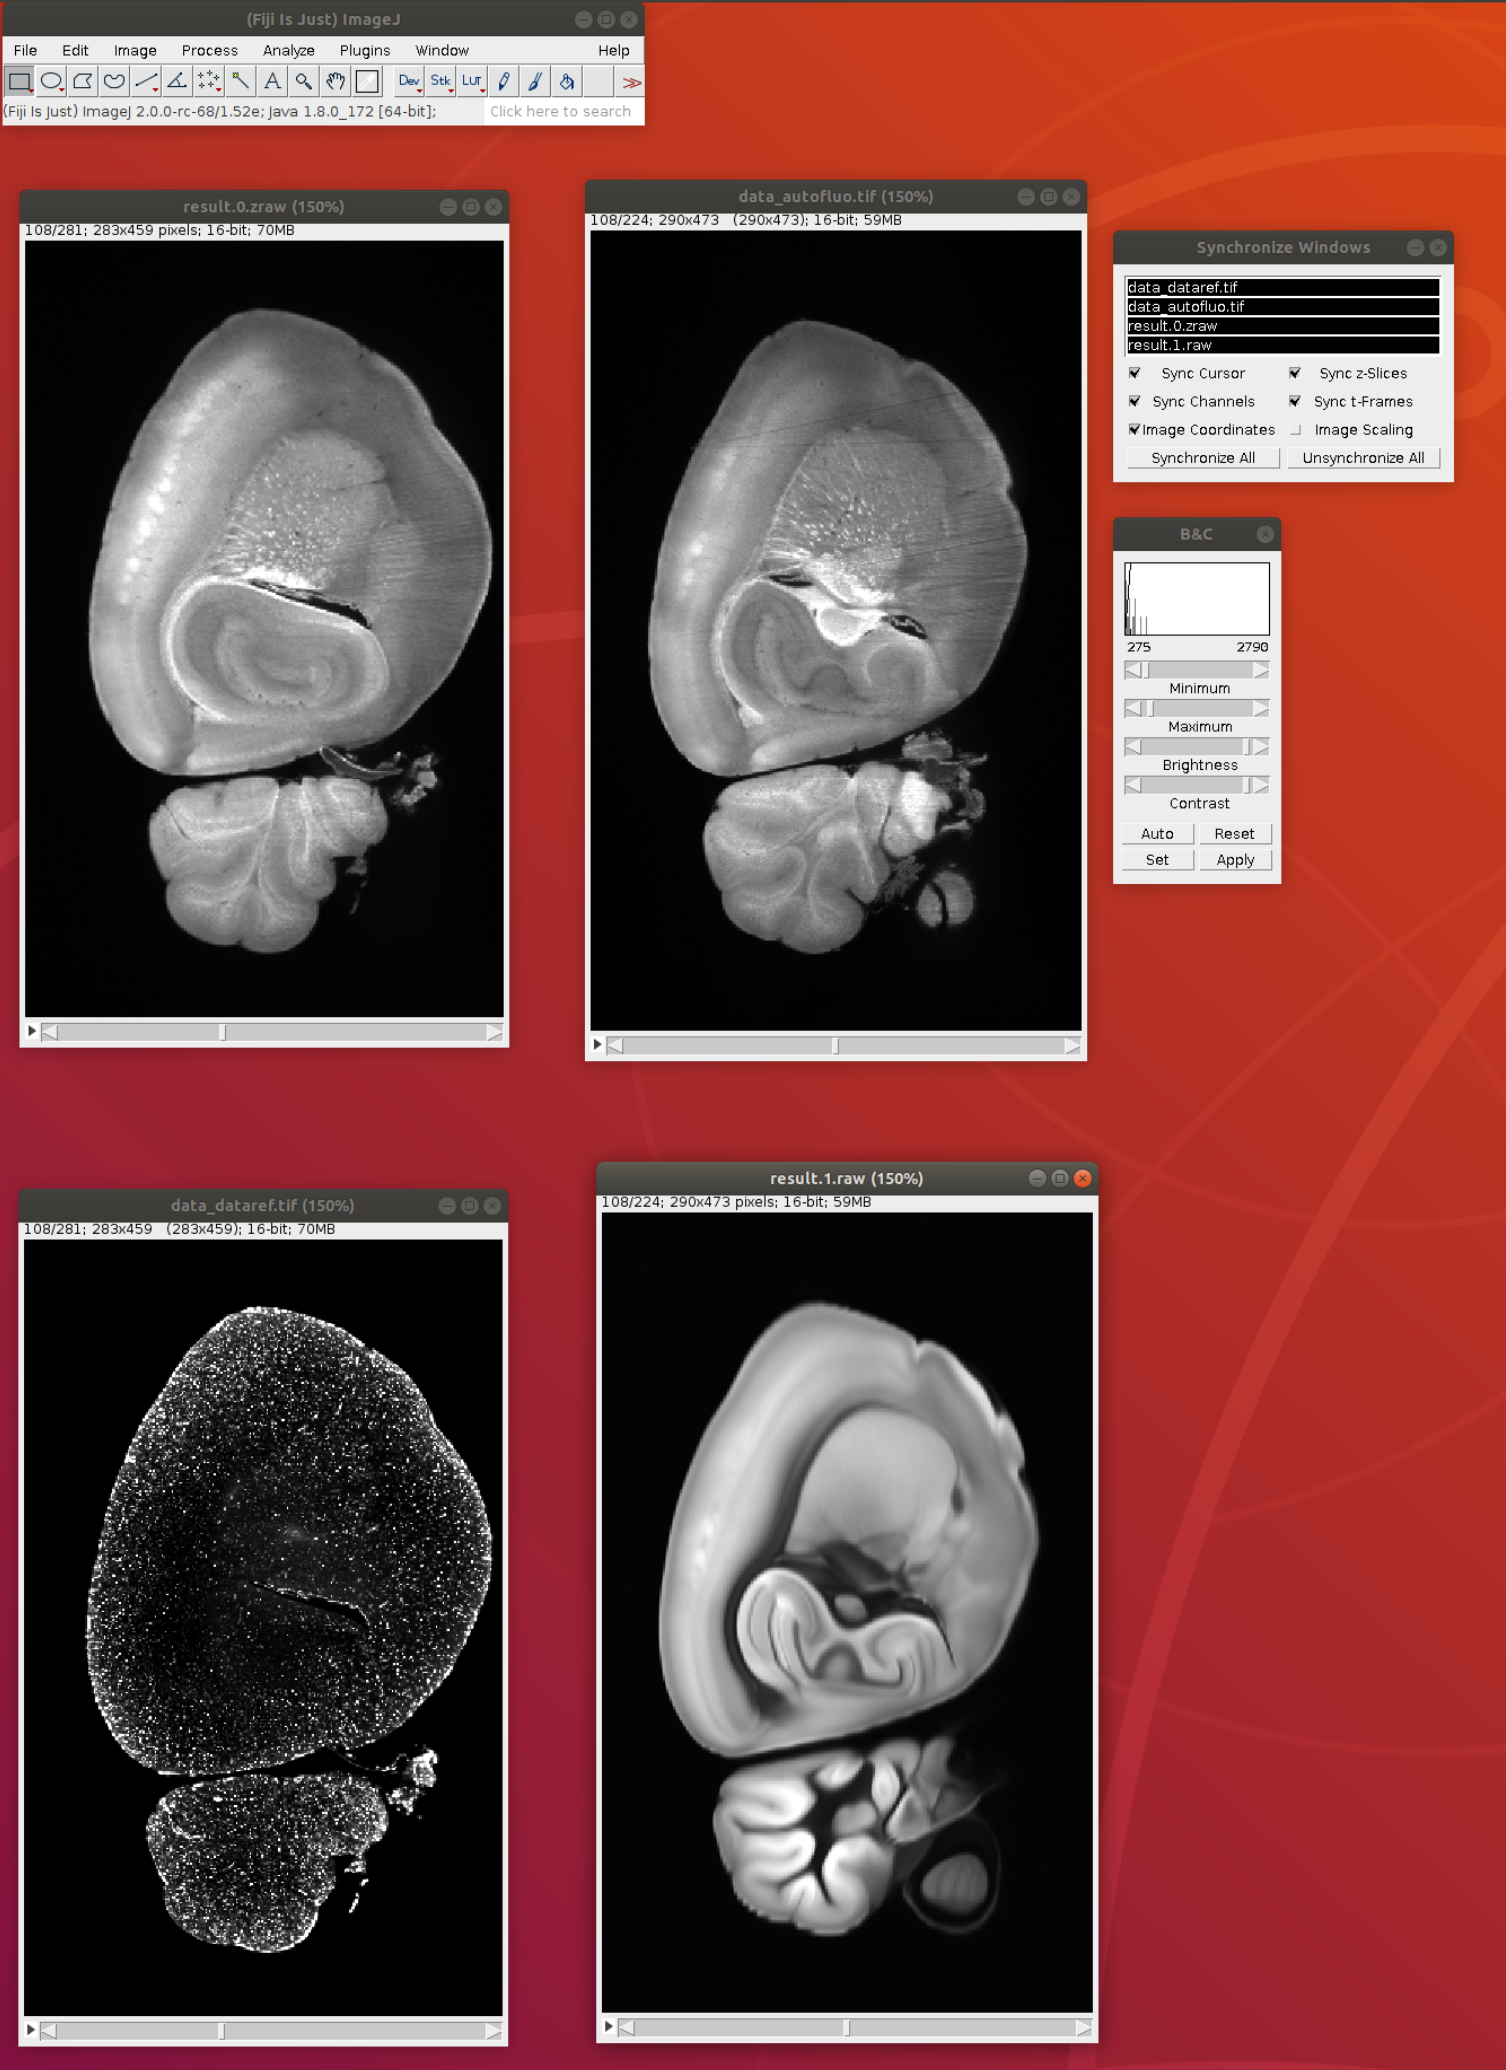

You can find the contrast adjustment panel in `Image -> Adjust -> Brightness/Contrast`. The synchronize windows tool can be found in `Analyze -> Tools -> Synchronize windows`. Click on `Synchronize all`, and travel through the stacks. With the mouse pointer, and make sure each aligned stack are well in sync with each other: make sure the outline of the brain is aligned, as well as the internal structures. Only the aligned data (images organized vertically here) have to match. If the alignment is good, you are then ready for the image processing steps.

## Create test data

This optional step allows to create a smaller sub-image from the full image in order to test the image processing
pipeline that follows.

When starting with a new data set, we highly recommend using this step to speed up processing and 
adjust the pipeline.

Skip this if you don't need to test the pipeline.

In [ ]:
##%% Crop test data 

# select subslice for testing the pipeline
slicing = (slice(2000,2200),slice(2000,2200),slice(50,80))
ws.create_debug('stitched', slicing=slicing)
ws.debug = True

# p3d.plot(ws.filename('stitched'))

If you like to create various test sets you can give each subset a name by setting `ws.debug = 'name_for_the_test_subset'` in the above code and run it again. 

You can switch between test sets by using `ws.debug = 'name_for_the_test_subset'`

Once the pipeline is performing well, you can switch to run it on the full data by setting `ws.debug = False`

You can see the effect of the debug mode on the filenames here:

In [ ]:
debug = ws.debug
ws.debug = False
print(ws.filename('stitched', directory=False))
ws.debug = True
print(ws.filename('stitched', directory=False))
ws.debug = 'test'
print(ws.filename('stitched', directory=False))
ws.debug = debug

## Cell detection

The next step is to detect the cells in the raw data.

In [ ]:
##%% Cell detection:

cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination_correction'] = None
cell_detection_parameter['background_correction'] = None
cell_detection_parameter['intensity_detection']['measure'] = ['source']
cell_detection_parameter['shape_detection']['threshold'] = 500

clearmap_io.delete_file(ws.filename('cells', postfix='maxima'))
cell_detection_parameter['maxima_detection']['save'] = ws.filename('cells', postfix='maxima')

processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100,  # 35,
    size_min = 30,  # 30,
    overlap  = 32,  # 10,
    verbose = True
)

cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix='raw'),
                   cell_detection_parameter=cell_detection_parameter, 
                   processing_parameter=processing_parameter)

Effectively this function performs the following steps:

* [illumination correction](#Illumination-correction)

* [background removal](#Background-removal)

* [equalization](#Equalization)

* [difference of Gaussians (DoG) filter](#DoG-Filter)

* [maxima detection](#Maxima-detection)

* [cell shape detection](#Shape-detection)

* [cell intensity measurements](#Intensity-detection)
    
  
The parameters for each step are passed as sub-dictionaries to the `cell_detection_parameter` dictionary:
  
* If None is passed for one of the steps this step is skipped.
  
* Each step also has an additional parameter `save` that enables saving of 
  the result of that step to a file to inspect the pipeline.

The details can be found [here](/api/ClearMap.ImageProcessing.Experts.Cells.html).

Let's look at the default parameter

In [ ]:
import ClearMap.Utils.HierarchicalDict as hdict
hdict.pprint(cells.default_cell_detection_parameter)

The following list the parameters for this step:

### Illumination correction
 
Illumination correction step parameter are set by the `illumincation_correction` dict using

* `flatfield` : array or str 
      The flat field estimate for the image planes.

* `background` : array or None
      A background level to assume for the flatfield correction.

* `scaling` : float, 'max', 'mean' or None
      Optional scaling after the flat field correction.

* `save` : str or None
      Save the result of this step to the specified file if not None.
 
 
### Background removal

`background_correction` : dict or None

* `shape` : tuple
      The shape of the structure element to estimate the background.
      This should be larger than the typical cell size.

* `form` : str
      The form of the structure element (e.g. 'Disk')

* `save` : str or None
      Save the result of this step to the specified file if not None.
  

### Equalization

`equalization` : dict or None

* `precentile` : tuple
      The lower and upper percentiles used to estimate the equalization.
      The lower percentile is used for normalization, the upper to limit the
      maximal boost to a maximal intensity above this percentile.

* `max_value` : float
      The maximal intensity value in the equalized image.

* `selem` : tuple
      The structural element size to estimate the percentiles. 
      Should be larger than the larger vessels.

* `spacing` : tuple
      The spacing used to move the structural elements.
      Larger spacings speed up processing but become locally less precise.

* `interpolate` : int
      The order of the interpolation used in constructing the full 
      background estimate in case a non-trivial spacing is used.

* `save` : str or None
      Save the result of this step to the specified file if not None.
  
  
### DoG Filter

`dog_filter` : dict or None
   
* `shape` : tuple
      The shape of the filter.
      This should be near the typical cell size.

* `sigma` : tuple or None
      The std of the inner Gaussian.
      If None, determined automatically from shape.

* `sigma2` : tuple or None
      The std of the outer Gaussian.
      If None, determined automatically from shape.

* `save` : str or None
      Save the result of this step to the specified file if not None.
  
  
### Maxima detection

`maxima_detection` : dict or None
 
* `h_max` : float or None
      The 'height' for the extended maxima.
      If None, simple local maxima detection is used.

* `shape` : tuple
      The shape of the structural element for extended maxima detection.
      This should be near the typical cell size.
    
* `threshold` : float or None
      Only maxima above this threshold are detected. If None, all maxima
      are detected.
    
* `save` : str or None
      Save the result of this step to the specified file if not None.


### Shape detection
  
`shape_detection` : dict or None

* `threshold` : float
      Cell shape is expanded from maxima if pixels are above this threshold
      and not closer to another maxima.
    
* `save` : str or None
      Save the result of this step to the specified file if not None.
 
 
### Intensity detection

`intensity_detection` : dict or None

* `method` : {'max'|'min','mean'|'sum'}
      The method to use to measure the intensity of a cell.
      
* `shape : tuple or None
      If no cell shapes are detected a disk of this shape is used to measure
      the cell intensity.
    
* `measure` : list of str
      Here the steps fat which te measurement should be taken is specified.
      E.g. to measure the raw intensity use 'source', to measure the background corrected intensity use 'background'

* `save : str or None
      Save the result of this step to the specified file if not None.m

The result can be visualized i different ways. 

We first overlay all unfiltered detected maxima (potential cell centers) with the raw data.

In [ ]:
p3d.plot([source, sink])

The result will look something like

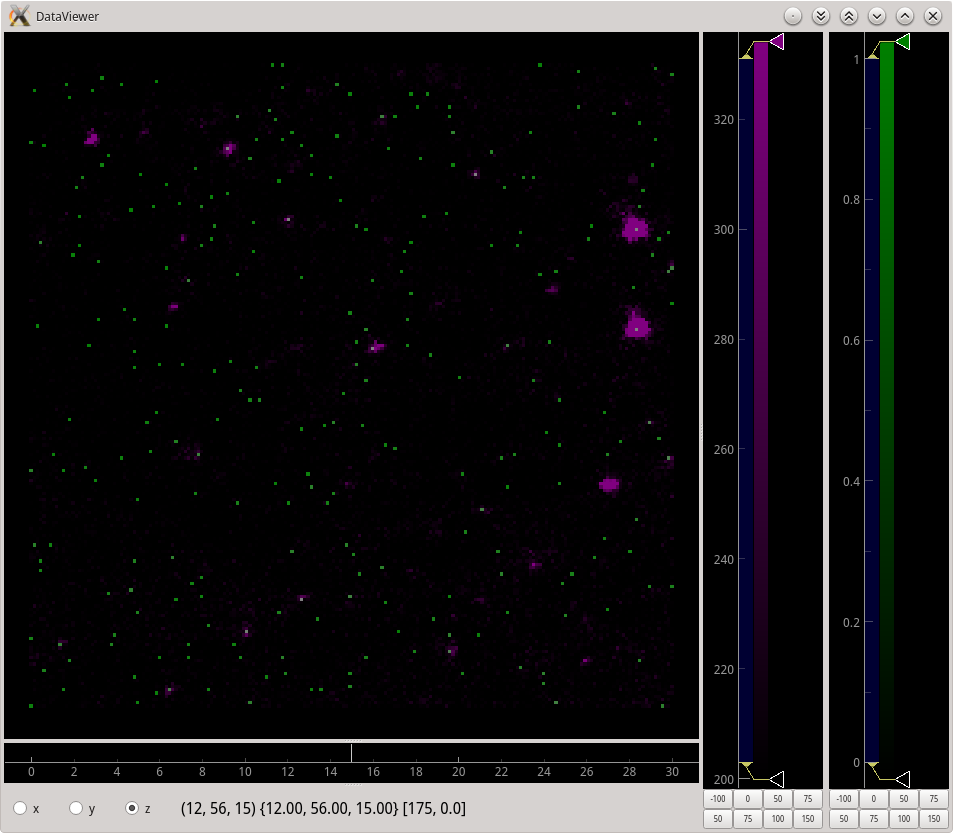

where the green dots are the potential maxima.

We can also plot the filtered maxima in 3d, though the validation of the results is typically better done browsing through the slices.

In [ ]:
coordinates = np.hstack([ws.source('cells', postfix='raw')[c][:,None] for c in 'xyz'])
p = vispy_p3d.list_plot_3d(coordinates)
vispy_p3d.plot_3d(ws.filename('stitched'), view=p, cmap=vispy_p3d.grays_alpha(alpha=1))

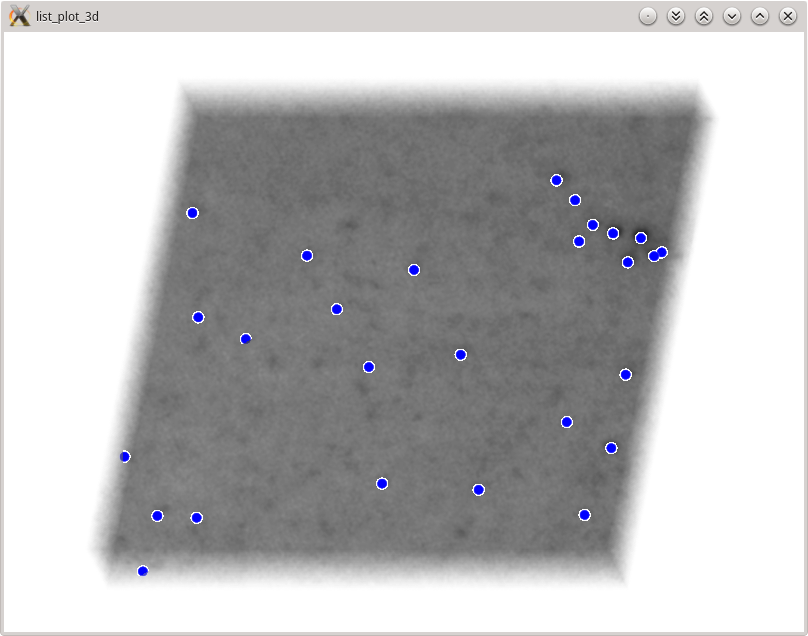

to adjust the parameter you can also plot some histograms:

In [ ]:
source = ws.source('cells', postfix='raw')

plt.figure(1); plt.clf()
names = source.dtype.names
nx,ny = plot_utils.subplot_tiling(len(names))
for i, name in enumerate(names):
    plt.subplot(nx, ny, i+1)
    plt.hist(source[name])
    plt.title(name)
plt.tight_layout()

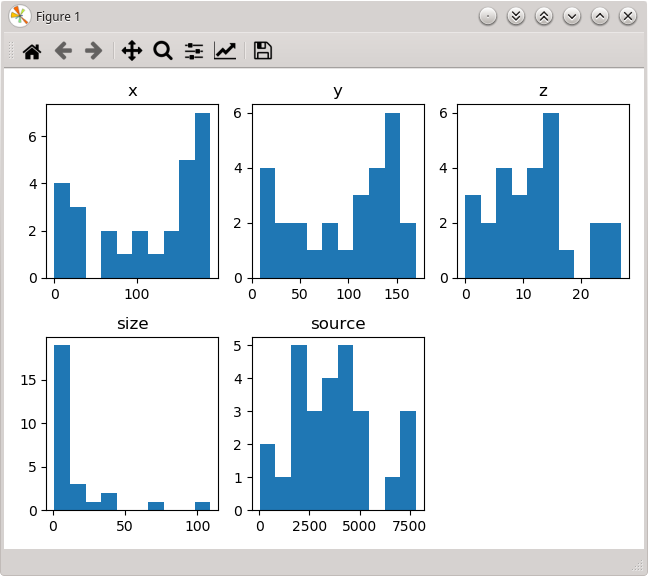

using this you can further filter the results:

##%% Filter cells

thresholds = {
    'source' : None,
    'size'   : (20,None)
    }

cells.filter_cells(source = ws.filename('cells', postfix='raw'), 
                   sink = ws.filename('cells', postfix='filtered'), 
                   thresholds=thresholds);

In [ ]:
coordinates = np.array([ws.source('cells', postfix='filtered')[c] for c in 'xyz']).T
p = vispy_p3d.list_plot_3d(coordinates, color=(1,0,0,0.5), size=10)
vispy_p3d.plot_3d(ws.filename('stitched'), view=p, cmap=vispy_p3d.grays_alpha(alpha=1))

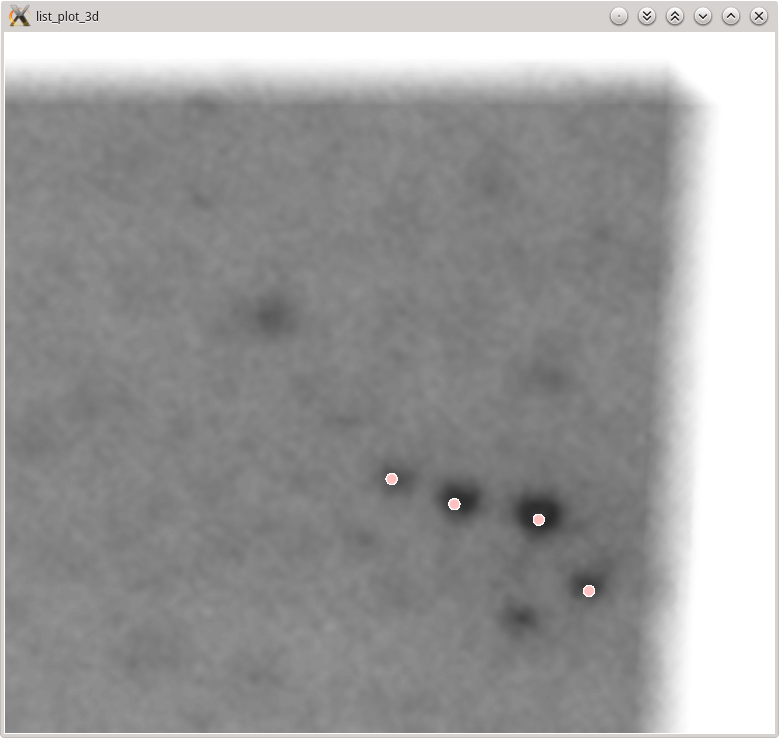

## Atlas alignment and annotation

Next, we align the cell coordinates to the atlas and use this to annotate the cells.

In [ ]:
##%% Cell alignment

source = ws.source('cells', postfix='filtered')

def transformation(coordinates):
    coordinates = res.resample_points(
        original_points=coordinates, orientation=None,
        original_shape=clearmap_io.shape(ws.filename('stitched')),
        resampled_shape=clearmap_io.shape(ws.filename('resampled'))
    )

    coordinates = elx.transform_points(
        coordinates, sink=None,
        transform_directory=ws.filename('resampled_to_auto'),
        binary=True, indices=False
    )

    coordinates = elx.transform_points(
        coordinates, sink=None,
        transform_directory=ws.filename('auto_to_reference'),
        binary=True, indices=False
    )

    return coordinates


coordinates = np.array([source[c] for c in 'xyz']).T

coordinates_transformed = transformation(coordinates)

In [ ]:
##%% Cell annotation

label = ano.label_points(coordinates_transformed, key='order')
names = ano.convert_label(label, key='order', value='name')

In [ ]:
##%% Save results

coordinates_transformed.dtype=[(t,float) for t in ('xt','yt','zt')]
label = np.array(label, dtype=[('order', int)])
names = np.array(names, dtype=[('name', 'U256')])

import numpy.lib.recfunctions as rfn
cells_data = rfn.merge_arrays([source[:], coordinates_transformed, label, names], 
                              flatten=True, usemask=False)

clearmap_io.write(ws.filename('cells'), cells_data)

## Analysis

We can  export this data for further analysis.

In [ ]:
##%% CSV export
df = pd.DataFrame(ws.source('cells'))
header = ', '.join(source.dtype.names)  # or ', '.join([h[0] for h in source.dtype.names])
df.to_csv(ws.filename('cells', extension='csv'), index=False, header=header)

If you prefer to work with files as generated by ClearMap1 you can use this export cell:

In [ ]:
##%% ClearMap1.0 export

source = ws.source('cells')

clearmap1_format = {'points' : ['x', 'y', 'z'], 
                    'points_transformed' : ['xt', 'yt', 'zt'],
                    'intensities' : ['source', 'dog', 'background', 'size']}

for filename, names in clearmap1_format.items():
    sink = ws.filename('cells', postfix=['ClearMap1', filename])
    data = np.array([source[name] if name in source.dtype.names else np.full(source.shape[0], np.nan) 
                     for name in names])
    clearmap_io.write(sink, data)

You can also perform analysis directly in ClearMap. The final section shows a simple example.

### Voxelization - cell density

In [ ]:
source = ws.source('cells')

coordinates = np.array([source[n] for n in ['xt','yt','zt']]).T
intensities = source['source']

In [ ]:
##%% Unweighted 

voxelization_parameter = dict(
      shape = clearmap_io.shape(annotation_file), 
      dtype = None, 
      weights = None,
      method = 'sphere', 
      radius = (7,7,7), 
      kernel = None, 
      processes = None, 
      verbose = True
)

vox.voxelize(coordinates, sink=ws.filename('density', postfix='counts'), **voxelization_parameter)

In [ ]:
##%% Weighted 

voxelization_parameter = dict(
      shape = clearmap_io.shape(annotation_file),
      dtype = None, 
      weights = intensities,
      method = 'sphere', 
      radius = (7,7,7), 
      kernel = None, 
      processes = None, 
      verbose = True
)

vox.voxelize(coordinates, sink=ws.filename('density', postfix='intensities'), **voxelization_parameter)

<div class="alert alert-info">
Note
    
You could also convert the data to a pandas DataFrame for further analysis. We tried to reduce the number of dependency packages for ClearMap and thus did not include this at this stage.
</div>

### Statistics


Cell counts or intensities of each sample in considered regions or annotated
brain areas between different groups can be compared using the independent
two sample student t-test assuming unequal variances. 

ClearMap as a discovery tool also provides correction for p-values for multiple 
comparison to q-values to control for false-discovery rate 

See the :mod:`ClearMap.Analysis.Statistics` module for more details.